In [2]:
import pysindy as ps

import deepSI
from deepSI import System_data
from deepSI.fit_systems import SS_encoder_general
from deepSI.fit_systems.encoders import default_encoder_net, default_state_net, default_output_net
from deepSI.fit_systems.fit_system import My_Simple_DataLoader, print_array_byte_size, Tictoctimer
import torch
from torch import nn

import numpy as np

from sklearn.preprocessing import PolynomialFeatures

from scipy.io import loadmat
import scipy.linalg as lin
import os

from utils import load_data
from data_processing import add_gaussian_noise

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import time
from copy import deepcopy
import itertools

import re

from feature_construction import feature_library
import polynomial as p
import fourier as f

from SI_SUBNET import SS_encoder_general_eq, h_identity, e_identity, simple_Linear
from SI_metrics import plot_coeff_grid, display_equation

c:\Users\Joost\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*****LOAD DATA*****

In [3]:
x_data, u_data, y_data, eq, T, U, set_idx = load_data(set="sc_wnl_noisy")
[N_arrow, N_train, N_val, N_test] = set_idx[0]

if T is None:
    T = np.eye(x_data.shape[-1])
if U is None:
    U = np.eye(u_data.shape[-1])

Data loaded from sc_wnl_noisy!


*****ORGANIZE DATA*****

In [4]:
# data organizing
x_arrow, u_arrow = x_data[:N_arrow], u_data[:N_arrow,0]
x_train, u_train = x_data[N_arrow:N_arrow+N_train,:], u_data[N_arrow:N_arrow+N_train,0]
x_val, u_val     = x_data[N_arrow+N_train-N_val:-N_test,:], u_data[N_arrow+N_train-N_val:-N_test,0]
x_test, u_test   = x_data[-N_test:,:], u_data[-N_test:]

# system data
arrow   = System_data(u=u_arrow, y=x_arrow)
train   = System_data(u=u_train, y=x_train)
val     = System_data(u=u_val[:1000], y=x_val[:1000,:]) # takes alot of time during training so take N_val approx >5nf
test    = System_data(u=u_test, y=x_test)

In [5]:
train.y.shape

(10000, 2)

*****SPECIFY FUNCTIONS TO BE CONSIDERED*****

In [4]:
functions = [p.f, f.sin, f.cos, f.sin2x, f.cos2x, f.sin3x, f.cos3x, f.sin4x, f.cos4x, f.sin5x, f.cos5x, f.sin6x, f.cos6x, f.sin7x, f.cos7x, f.sin8x, f.cos8x, f.sin9x, f.cos9x, f.sin10x, f.cos10x]
poly = feature_library(functions=functions, nx=2, nu=1, T=T, U=U)

*****INITIALIZE NETWORK*****

In [5]:
batch_size = 64

# network param
nx, nu = 2, 1 # state dimension and inputs
na, nb = 0, 0
na_right = 1

f_net_kwargs = {"feature_library": poly, "u": nu, "nf": poly.feature_number()}

# output model
h_net = h_identity
h_net_kwargs = {}

# encoder model
e_net = e_identity
e_net_kwargs = {}

# SI-SUBNET initialization
fit_sys = SS_encoder_general_eq(nx=nx, na=na, nb=nb, na_right=na_right,\
                                f_net_kwargs=f_net_kwargs,\
                                e_net=e_net, e_net_kwargs=e_net_kwargs,\
                                h_net=h_net, h_net_kwargs=h_net_kwargs)

*****PRETRAIN 1STEP AHEAD*****

In [6]:
nf = 1

# regularization
gamma = 0
mode = None
T_idx = None

# pruning
pruning = False
epo_idx = 500
threshold = 5e-5

loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, threshold=threshold, epo_idx=epo_idx)

fit_sys.fit(train, val, epochs=100, batch_size = 64, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

Initilizing the model and optimizer
Size of the training array =  624.9 kB
N_training_samples = 9999, batch_size = 64, N_batch_updates_per_epoch = 156
Initial Validation sim-NRMS= 2.9868903853467854


  0%|          | 0/100 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 1.65807324350183
Epoch    1, sqrt loss  0.2324, Val sim-NRMS  1.658, Time Loss: 50.9%, data: 6.3%, val: 42.1%, 493.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 1.1064191864234316
Epoch    2, sqrt loss  0.1343, Val sim-NRMS  1.106, Time Loss: 46.1%, data: 7.1%, val: 44.3%, 493.1 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.8124152696843563
Epoch    3, sqrt loss 0.08266, Val sim-NRMS 0.8124, Time Loss: 48.2%, data: 4.7%, val: 45.3%, 491.5 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.6390040680370297
Epoch    4, sqrt loss 0.05962, Val sim-NRMS  0.639, Time Loss: 47.4%, data: 4.5%, val: 45.6%, 494.0 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.6007848037153948
Epoch    5, sqrt loss 0.04959, Val sim-NRMS 0.6008, Time Loss: 46.1%, data: 5.5%, val: 46.4%, 496.5 batches/s

*****TRAIN N STEP AHEAD WITH CHOSEN NF*****

In [8]:
# regularization
gamma = 1e-2
mode = None
T_idx = None

# pruning
pruning = True
epo_idx = 10
threshold = 5e-5

nf = 5
loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, threshold=threshold, epo_idx=epo_idx)
fit_sys.fit(train, val, epochs=50, batch_size = batch_size, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False)

nf = 10
loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, threshold=threshold, epo_idx=epo_idx)
fit_sys.fit(train, val, epochs=10, batch_size = batch_size, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False)

nf = 25
loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, threshold=threshold, epo_idx=epo_idx)
fit_sys.fit(train, val, epochs=10, batch_size = batch_size, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False)

nf = 50
loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, threshold=threshold, epo_idx=epo_idx)
fit_sys.fit(train, val, epochs=10, batch_size = batch_size, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False)

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  1.5 MB
N_training_samples = 9995, batch_size = 64, N_batch_updates_per_epoch = 156
Initial Validation sim-NRMS= 0.11807852156639903


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch    1, sqrt loss   0.183, Val sim-NRMS 0.09988, Time Loss: 76.4%, data: 2.7%, val: 20.4%, 276.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.09636685723714303
Epoch    2, sqrt loss  0.1831, Val sim-NRMS 0.09637, Time Loss: 71.0%, data: 1.3%, val: 27.5%, 246.6 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.08899831640408451
Epoch    3, sqrt loss  0.1831, Val sim-NRMS  0.089, Time Loss: 68.0%, data: 1.4%, val: 30.4%, 241.2 batches/sec
Epoch    4, sqrt loss   0.183, Val sim-NRMS  0.103, Time Loss: 69.9%, data: 1.3%, val: 28.4%, 248.1 batches/sec
Epoch    5, sqrt loss   0.183, Val sim-NRMS 0.1031, Time Loss: 71.6%, data: 1.4%, val: 26.7%, 246.4 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.08807206451399772
Epoch    6, sqrt loss  0.1831, Val sim-NRMS 0.08807, Time Loss: 70.4%, data: 1.2%, val: 28.1%, 240.0 batches/sec
Epoch    7, sqrt loss   0.183, Val sim-NRMS 0.09612, Ti

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch    1, sqrt loss  0.1831, Val sim-NRMS 0.09313, Time Loss: 83.7%, data: 1.4%, val: 14.7%, 153.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.08683333490281167
Epoch    2, sqrt loss  0.1831, Val sim-NRMS 0.08683, Time Loss: 72.4%, data: 1.9%, val: 25.5%, 136.6 batches/sec
Epoch    3, sqrt loss  0.1831, Val sim-NRMS 0.08942, Time Loss: 74.1%, data: 3.2%, val: 22.5%, 145.0 batches/sec
Epoch    4, sqrt loss  0.1831, Val sim-NRMS 0.0882, Time Loss: 76.2%, data: 3.0%, val: 20.7%, 150.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.08366252213071251
Epoch    5, sqrt loss  0.1831, Val sim-NRMS 0.08366, Time Loss: 74.9%, data: 2.7%, val: 22.3%, 148.1 batches/sec
Epoch    6, sqrt loss  0.1831, Val sim-NRMS 0.09227, Time Loss: 76.4%, data: 2.3%, val: 21.1%, 151.0 batches/sec
Epoch    7, sqrt loss  0.1831, Val sim-NRMS 0.08603, Time Loss: 77.9%, data: 2.1%, val: 19.9%, 151.0 batches/sec
Epoch    8, sqrt loss  0.1831,

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch    1, sqrt loss  0.1831, Val sim-NRMS 0.08615, Time Loss: 94.1%, data: 0.1%, val: 5.7%, 53.1 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.08300786955489213
Epoch    2, sqrt loss  0.1831, Val sim-NRMS 0.08301, Time Loss: 90.7%, data: 0.6%, val: 8.6%, 51.5 batches/sec
Epoch    3, sqrt loss  0.1831, Val sim-NRMS 0.08387, Time Loss: 91.6%, data: 0.8%, val: 7.6%, 52.7 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.08067309051196943
Epoch    4, sqrt loss  0.1831, Val sim-NRMS 0.08067, Time Loss: 90.8%, data: 0.6%, val: 8.6%, 51.7 batches/sec
Epoch    5, sqrt loss  0.1831, Val sim-NRMS 0.08154, Time Loss: 91.4%, data: 0.5%, val: 8.1%, 51.9 batches/sec
Epoch    6, sqrt loss  0.1831, Val sim-NRMS 0.08463, Time Loss: 91.8%, data: 0.4%, val: 7.8%, 51.6 batches/sec
Epoch    7, sqrt loss  0.1831, Val sim-NRMS 0.08241, Time Loss: 92.1%, data: 0.4%, val: 7.5%, 51.3 batches/sec
Epoch    8, sqrt loss  0.1831, Val sim-NRMS

  0%|          | 0/10 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.08048234112931187
Epoch    1, sqrt loss  0.1831, Val sim-NRMS 0.08048, Time Loss: 93.5%, data: 0.4%, val: 5.8%, 24.7 batches/sec
Epoch    2, sqrt loss  0.1832, Val sim-NRMS 0.08185, Time Loss: 94.9%, data: 0.4%, val: 4.3%, 24.8 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.0802935473702291
Epoch    3, sqrt loss  0.1832, Val sim-NRMS 0.08029, Time Loss: 94.5%, data: 0.3%, val: 4.9%, 24.8 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.08002393556698442
Epoch    4, sqrt loss  0.1832, Val sim-NRMS 0.08002, Time Loss: 94.3%, data: 0.3%, val: 5.1%, 24.7 batches/sec
Epoch    5, sqrt loss  0.1832, Val sim-NRMS 0.08101, Time Loss: 94.8%, data: 0.3%, val: 4.6%, 24.8 batches/sec
Epoch    6, sqrt loss  0.1832, Val sim-NRMS 0.08042, Time Loss: 95.1%, data: 0.4%, val: 4.4%, 24.9 batches/sec
Epoch    7, sqrt loss  0.1832, Val sim-NRMS 0.08167, Time Loss: 9

*****TRAIN FOR X EPOCHS WITHOUT REG/PRUNING*****

In [9]:
# regularization
gamma = 0
# pruning
pruning = False

loss_kwargs= dict(nf=nf+1, save_params=True, gamma=gamma, mode=mode, T_idx=T_idx, pruning=pruning, threshold=threshold, epo_idx=epo_idx)
fit_sys.fit(train, val, epochs=10, batch_size = batch_size, optimizer_kwargs={"lr": 1e-3}, loss_kwargs=loss_kwargs, auto_fit_norm=False, early_stopping=False, load_best=False)

Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  11.8 MB
N_training_samples = 9950, batch_size = 64, N_batch_updates_per_epoch = 155
Initial Validation sim-NRMS= 0.08055179388423231


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch    1, sqrt loss 0.01828, Val sim-NRMS 0.08162, Time Loss: 97.3%, data: 0.3%, val: 2.3%, 21.6 batches/sec
Epoch    2, sqrt loss 0.01829, Val sim-NRMS 0.08157, Time Loss: 97.3%, data: 0.4%, val: 2.3%, 21.8 batches/sec
Epoch    3, sqrt loss 0.01832, Val sim-NRMS 0.08082, Time Loss: 97.4%, data: 0.3%, val: 2.3%, 21.8 batches/sec
Epoch    4, sqrt loss  0.0183, Val sim-NRMS 0.08083, Time Loss: 97.3%, data: 0.3%, val: 2.4%, 21.9 batches/sec
Epoch    5, sqrt loss  0.0183, Val sim-NRMS 0.07977, Time Loss: 97.3%, data: 0.3%, val: 2.4%, 21.8 batches/sec
Epoch    6, sqrt loss 0.01828, Val sim-NRMS 0.0816, Time Loss: 97.2%, data: 0.2%, val: 2.4%, 21.9 batches/sec
Epoch    7, sqrt loss 0.01829, Val sim-NRMS 0.08228, Time Loss: 97.3%, data: 0.3%, val: 2.4%, 21.9 batches/sec
Epoch    8, sqrt loss 0.01831, Val sim-NRMS 0.08351, Time Loss: 97.2%, data: 0.3%, val: 2.3%, 21.7 batches/sec
Epoch    9, sqrt loss 0.01829, Val sim-NRMS 0.08049, Time Loss: 97.2%, data: 0.3%, val: 2.4%, 21.7 batches/sec
Ep

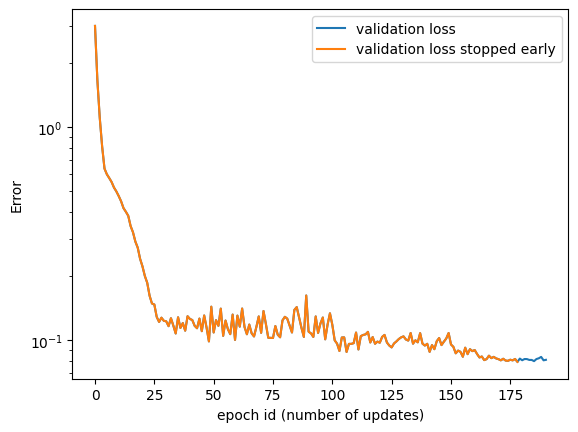

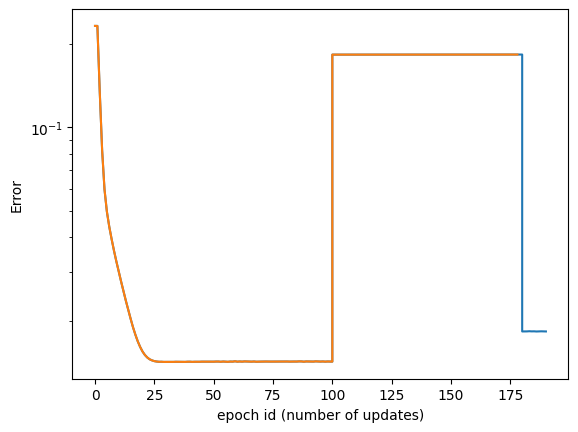

In [10]:
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_val,label='validation loss') 
#or use fit_sys_ss_enc.epoch_id for epochs

plt.xlabel('epoch id (number of updates)')
plt.ylabel('Error')

fit_sys.checkpoint_load_system('_best')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_val,label='validation loss stopped early')
plt.legend()
plt.show()


fit_sys.checkpoint_load_system('_last')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_train**0.5,label='train sqrt loss')
fit_sys.checkpoint_load_system('_best')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_train**0.5,label='train sqrt loss stopped early')
plt.xlabel('epoch id (number of updates)')
plt.ylabel('Error')
plt.show()


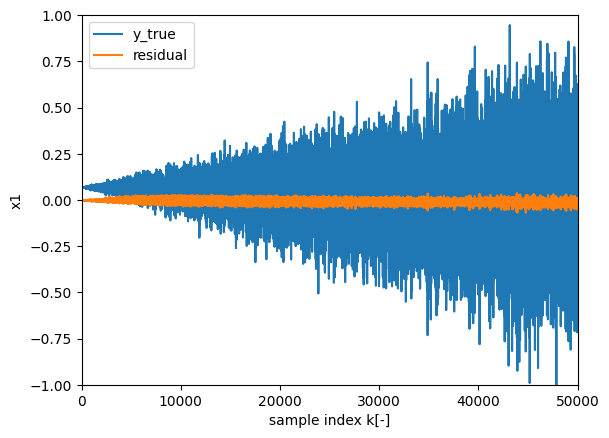

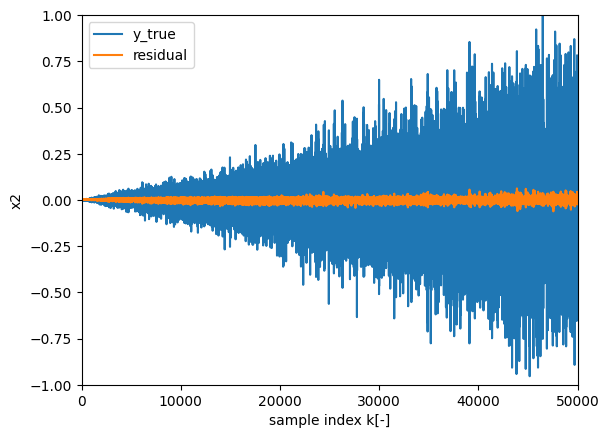

arrow test set simulation SS encoder, NRMS = 0.07042906176656873


In [11]:
arrow_sim_enc = fit_sys.apply_experiment(arrow)

plt.plot(arrow.y[:,0])
plt.plot(arrow.y[:,0]-arrow_sim_enc.y[:,0])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.xlim([0, arrow.y[:,0].size])
plt.ylim([-1,1])
plt.show()

plt.plot(arrow.y[:,1])
plt.plot(arrow.y[:,1]-arrow_sim_enc.y[:,1])
plt.xlabel("sample index k[-]")
plt.ylabel("x2")
plt.legend(["y_true","residual"])
plt.xlim([0, arrow.y[:,1].size])
plt.ylim([-1,1])
plt.show()

print(f'arrow test set simulation SS encoder, NRMS = {arrow_sim_enc.NRMS(arrow)}')

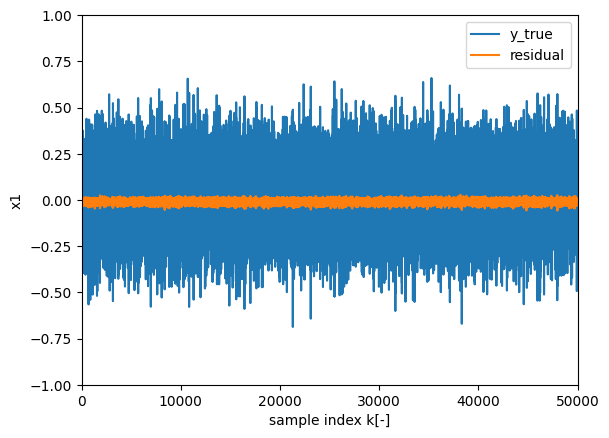

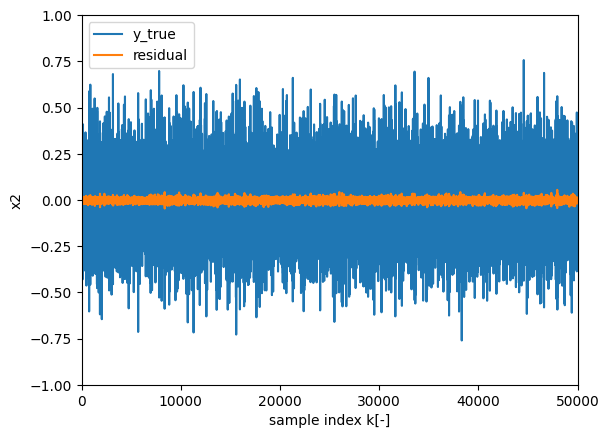

multisin test set simulation SS encoder, NRMS = 0.07106936773477518


In [12]:
test_sim_enc = fit_sys.apply_experiment(test)

plt.plot(test.y[:,0])
plt.plot(test.y[:,0]-test_sim_enc.y[:,0])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.xlim([0, test.y[:,0].size])
plt.ylim([-1,1])
plt.show()

plt.plot(test.y[:,1])
plt.plot(test.y[:,1]-test_sim_enc.y[:,1])
plt.xlabel("sample index k[-]")
plt.ylabel("x2")
plt.legend(["y_true","residual"])
plt.xlim([0, test.y[:,1].size])
plt.ylim([-1,1])
plt.show()

print(f'multisin test set simulation SS encoder, NRMS = {test_sim_enc.NRMS(test)}')

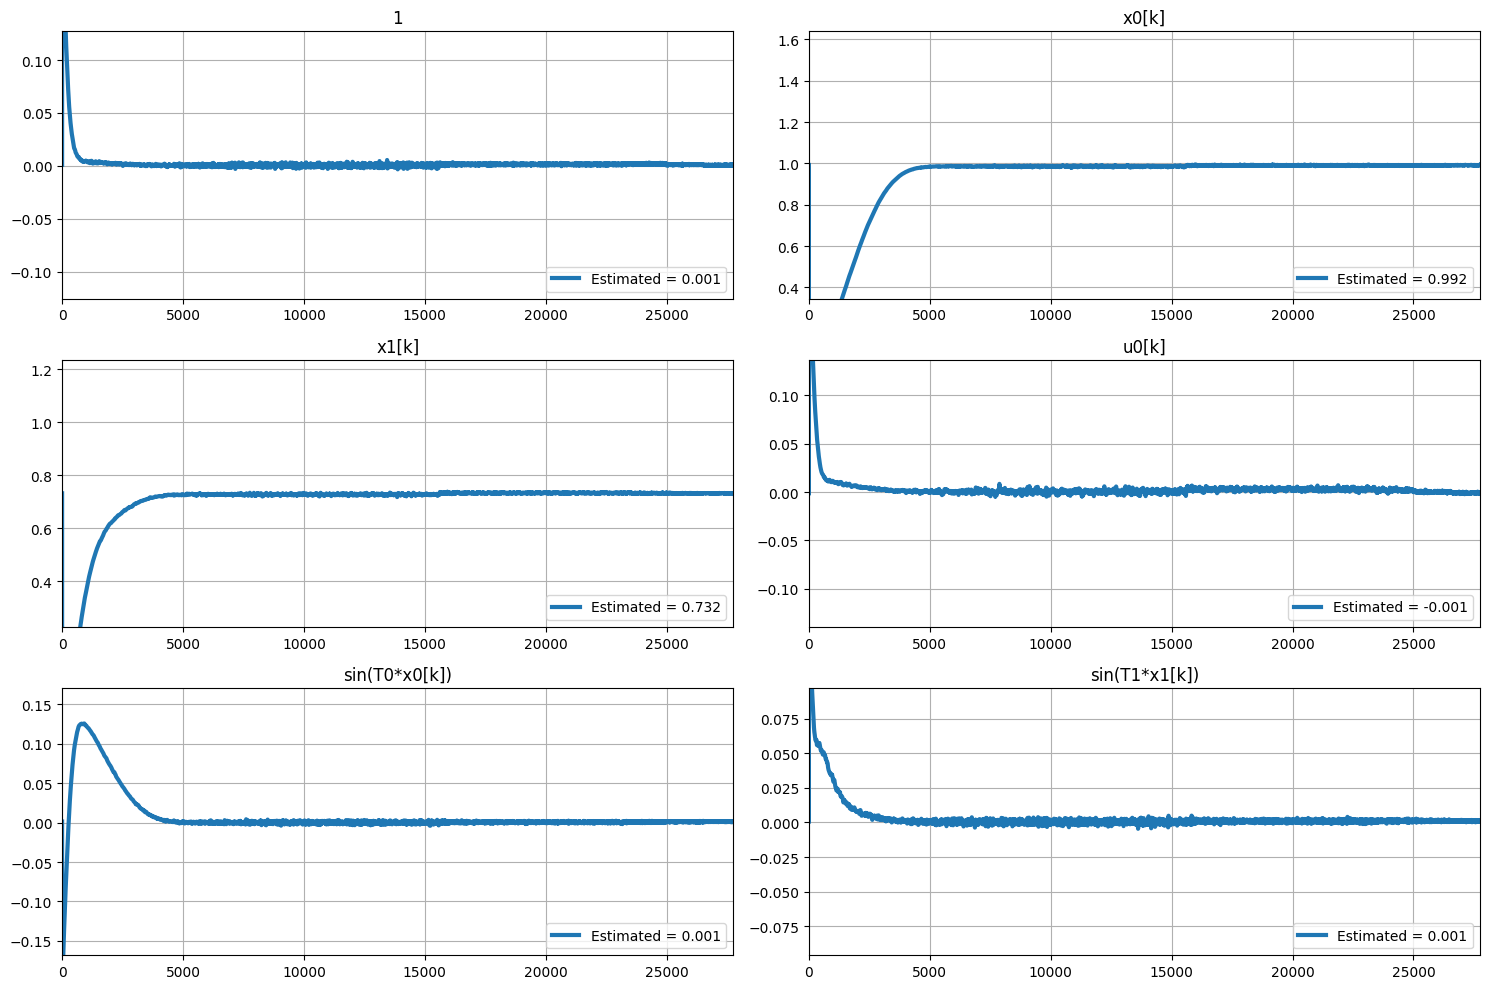

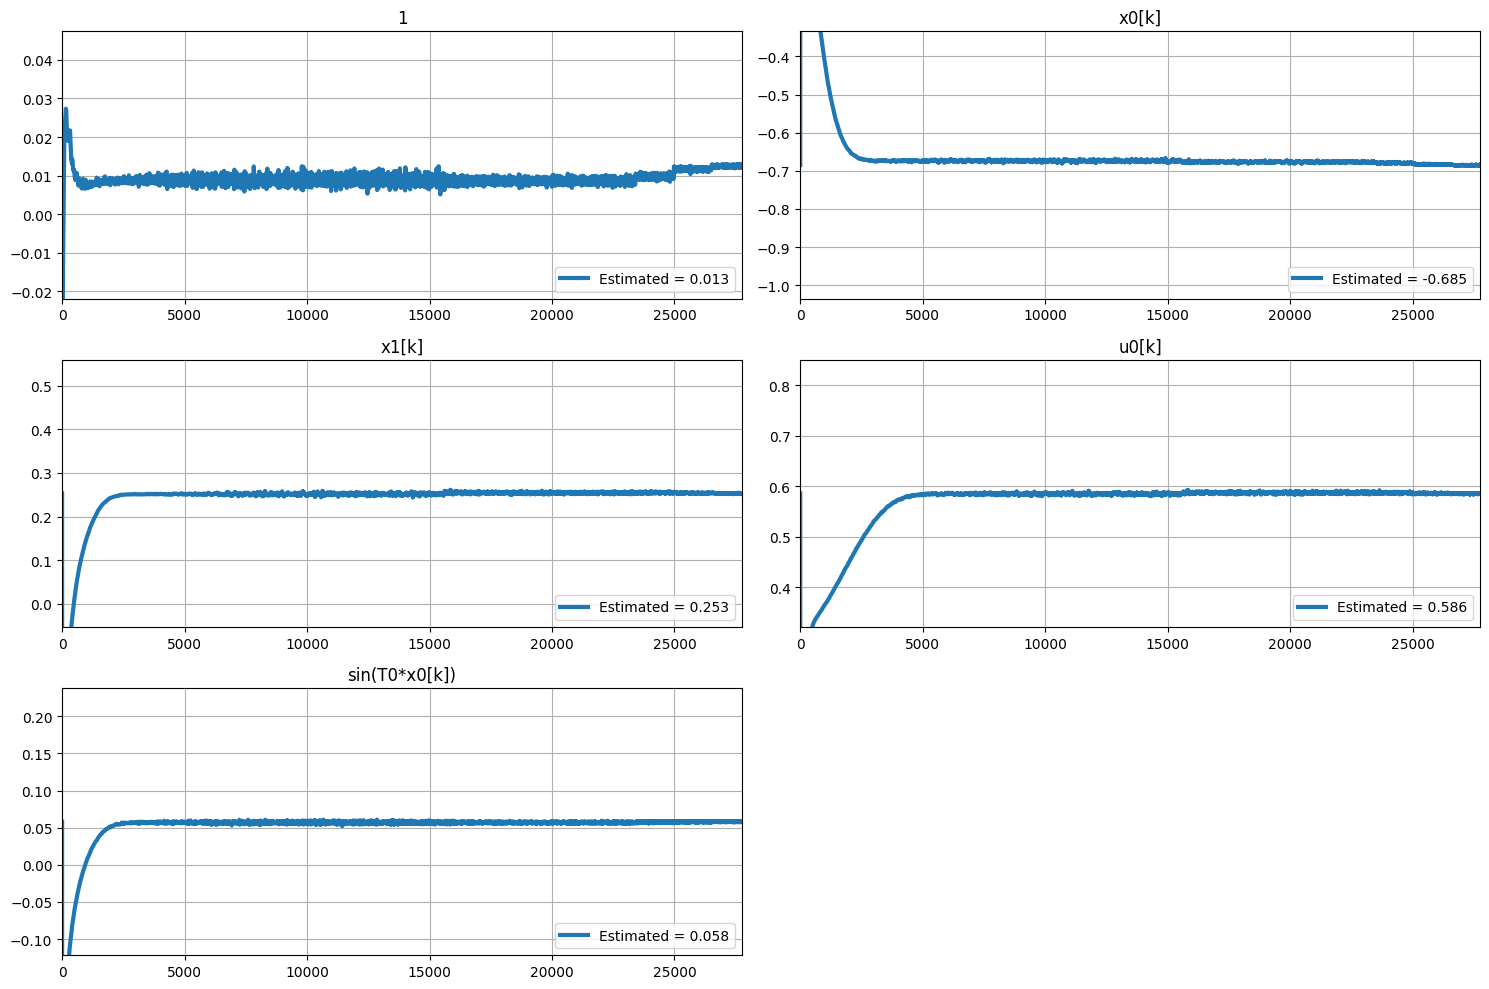

In [15]:
coeff = fit_sys.coefficients
coeff = np.array(coeff).T
plot_coeff_grid(coeff, states=2, labels=poly.feature_names, save=False, precision=3, threshold=0)

In [16]:
# coeff = fit_sys.coefficients
# coeff = np.array(coeff)

# for i in range(coeff.shape[-1]//2):
#     if not coeff[-1,i]==0:
#         plt.plot(coeff[:,i])
# plt.show()

# for i in range(coeff.shape[-1]//2):
#     if not coeff[-1,coeff.shape[-1]//2+i]==0:
#         plt.plot(coeff[:,coeff.shape[-1]//2+i])
# plt.show()

In [17]:
fit_sys.fn.layer.weight.data, poly.feature_names

(tensor([[ 9.2764e-04,  9.9226e-01,  7.3214e-01, -1.2433e-03,  1.2899e-03,
           6.7201e-04,  1.2042e-04],
         [ 1.2849e-02, -6.8477e-01,  2.5344e-01,  5.8614e-01,  5.8160e-02,
          -0.0000e+00,  0.0000e+00]]),
 ['1',
  'x0[k]',
  'x1[k]',
  'u0[k]',
  'sin(T0*x0[k])',
  'sin(T1*x1[k])',
  'sin(U0*u0[k])'])

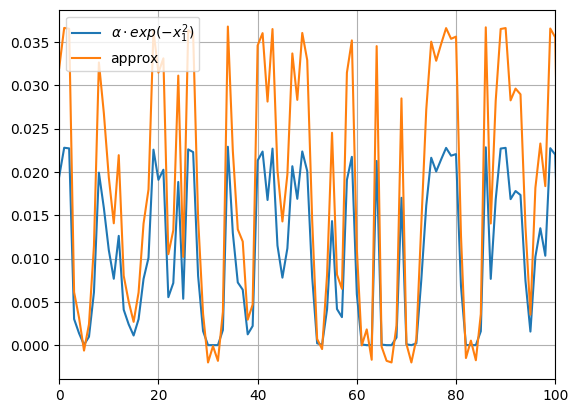

In [18]:
# plt.plot(val.y[1:,1]-0.6330*val.y[:-1,0]+0.2517*val.y[:-1,1]+0.7103*val.u[:-1]+0.055*np.sin(1/T[0,0]*val.y[:-1,0]))
plt.plot(0.022917*np.exp(-(val.y[:,0]/T[0,0])**2),label="$\\alpha \\cdot exp(-x_{1}^{2})$")
plt.plot((0.0108*np.ones(val.y[:,0].shape)+0.0173*np.cos(1/T[0,0]*val.y[:,0])+0.0066*np.cos(2/T[0,0]*val.y[:,0])+0.0021*np.cos(3/T[0,0]*val.y[:,0])),label="approx")
plt.legend()
plt.xlim([0,100])
plt.grid()
plt.show()

In [19]:
# display_equation(coeff[:,-1:], poly.feature_names,threshold=0.00001, precision=6)
# print()
print(eq[0]+"\n"+eq[1])

x0[k+1] = 1.0*x_0[k]+0.743139*x_1[k]                                                                    
x1[k+1] = -0.676223*x_0[k]+0.250601*x_1[k]+0.583582*u_0[k]+0.056569*sin(x_0[k])+0.011368*exp(-x_0[k]**2)
